In [17]:
##### Parameters
path_train_set = "./Data/Patches_train/"
path_test_set = "./Data/Patches_test/"

In [24]:
# Pytorch
import torch as T
import torch.nn as nn
from torch.utils.data import random_split
import torch.optim as optim

# Torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Perso
from customNet import Net

In [43]:
device = 'cuda' if T.cuda.is_available() else 'cpu'
print("Device : "+ device)
print()

net = Net()
print("Network architecture : ")
print(net.to(device))

Device : cuda

Network architecture : 
Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=41472, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_featu

In [44]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()])

batch_size = 32

train_set = ImageFolder(path_train_set, transform=transform)
test_set = ImageFolder(path_test_set, transform=transform)

train_size = int(0.85 * len(train_set))
valid_size = len(train_set) - train_size
train_set, valid_set = random_split(train_set, [train_size, valid_size])

train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

valid_loader = T.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), 
                          lr=0.001, lr_decay=0,
                          weight_decay=0.004,
                          initial_accumulator_value=0,
                          eps=1e-10)

In [65]:
# Apprentissage
# Vous pouvez à tout moment interompre le noyau pour vous arréter à l'epoch actuelle

epoch = 10
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

for epoch in range(0, epoch):
    net.train()
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):

        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)

    # VALIDATION LOOP
    with T.no_grad():
        correct = 0
        total = 0
        valid_running_loss = .0
        for data in valid_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        valid_running_loss /= len(valid_loader)
        valid_loss.append(valid_running_loss)
        valid_running_acc = correct / total
        valid_acc.append(valid_running_acc)

        if epoch % 10 == 0 or True:
            print('\nEpoch: {}'.format(epoch))
            print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
            print('Train Loss => {:.5f}'.format(running_loss))
            print('valid Acc.  => {:.3f}%'.format(100 * valid_running_acc), end=' | ')
            print('valid Loss  => {:.5f}'.format(valid_running_loss))

print('Finished Training')



Epoch: 0
Train Acc. => 67.331% | Train Loss => 0.60831
valid Acc.  => 67.769% | valid Loss  => 0.60343

Epoch: 1
Train Acc. => 67.895% | Train Loss => 0.60572
valid Acc.  => 68.540% | valid Loss  => 0.59778

Epoch: 2
Train Acc. => 67.370% | Train Loss => 0.60454
valid Acc.  => 68.871% | valid Loss  => 0.59657

Epoch: 3
Train Acc. => 67.467% | Train Loss => 0.60364
valid Acc.  => 68.650% | valid Loss  => 0.59331

Epoch: 4
Train Acc. => 68.167% | Train Loss => 0.60235
valid Acc.  => 69.311% | valid Loss  => 0.59370


KeyboardInterrupt: 

In [66]:
#####
# Test loop pour obtenir accuracy pour chaque classe
#####


classes = ('Good','Bad')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0
total = 0

with T.no_grad():
    for data in test_loader:
        images, labels = data
        if device == 'cuda':
            images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = T.max(outputs, 1)
        
        # Prédiction globale
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        
        # Prédiction pour chaque classe
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

            
print(f'Accuracy complète sur le test set: {100 * correct // total} %')
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy pour la classe: {classname:5s} is {accuracy:.1f} %')



Accuracy complète sur le test set: 66 %
Accuracy pour la classe: Good  is 60.2 %
Accuracy pour la classe: Bad   is 71.8 %


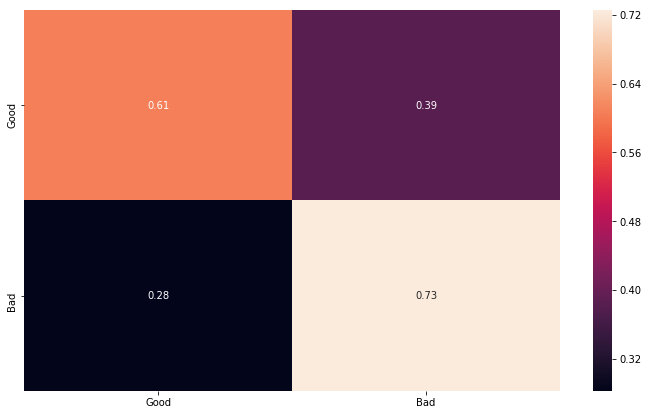

In [67]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


y_pred = []
y_true = []

# on parcours test data
for inputs, labels in test_loader:
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)
            
        # envoie dans le modèle
        output = net(inputs)
        
        # on regarde la prédiction
        output = (T.max(T.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        # et on sauvegarde le vrai label
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)
        
classes = ('Good', 'Bad')

#cf_matrix = confusion_matrix(y_true, y_pred,normalize='true')
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *2, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

[0.6083100750024274, 0.60572125822861, 0.6045430122140032, 0.6036439749024669, 0.6023457018855196]


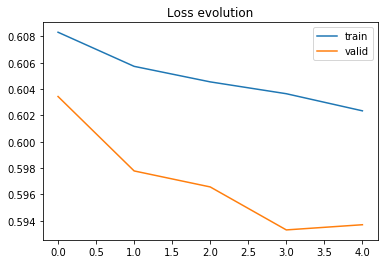

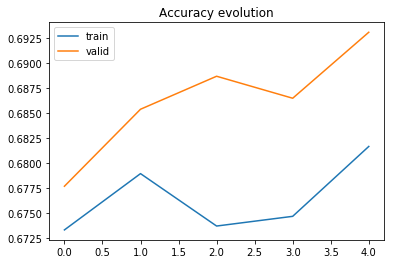

In [68]:
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.title("Loss evolution")
plt.legend()
plt.show()

plt.title("Accuracy evolution")
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.legend()
plt.show()

In [70]:
#T.save(net.state_dict(), "path")
T.save(net, "trained_net_test")